In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec

import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import KFold

from sklearn.base import clone as sklearn_clone

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

import matplotlib.pyplot as plt

import spacy
from sentimentpl.models import SentimentPLModel
from autocorrect import Speller

import re
import unicodedata

from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7,progress_bar=True)

from parallelbar import progress_map

import pyphen
import re

from sklearn.preprocessing import StandardScaler

import seaborn as sns

nlp_core = spacy.load("pl_core_news_lg")
model_sent = SentimentPLModel(from_pretrained='latest')
spell = Speller('pl')
syllab = pyphen.Pyphen(lang='pl')
stopwords = nlp_core.Defaults.stop_words

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Lodad data

In [2]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_cz_to_use.csv', sep=';')

df = df.reset_index(drop=True)

y_train = df.copy()['assestment']
X_train = df.copy()[['text_clean', 'words_clean']]

X_train['text_clean'] = X_train['text_clean'].apply( 
    lambda x:
    (x
     .replace('\n', ' ')
     .replace('ą', 'ą')
     .replace('ć', 'ć')
     .replace('ę', 'ę')
     .replace('ń', 'ń')
     .replace('ó', 'ó')
     .replace('ś', 'ś')
     .replace('ź', 'ź')
     .replace('ż', 'ż'))
)

In [3]:
y_train.shape

(2409,)

In [4]:
X_train.shape

(2409, 2)

## Get lexical features

In [5]:
def get_vowels_per_word(t):
    vowels = [len(re.findall('[aeiouóyąę]+', w)) for w in re.findall('(?![\d\s])[\w]+(?![\d\s])', t)]
    vowels = np.array(vowels)
    vowels = vowels[vowels>0]
    
    if vowels.shape[0] == 0:
        return [0]
    return vowels

In [6]:
# https://github.com/Hassaan-Elahi/Writing-Styles-Classification-Using-Stylometric-Analysis/blob/master/Detailed%20Report.pdf

In [7]:
X_train['avg_word_len'] = X_train['text_clean'].progress_apply(
    lambda x: np.mean(
        [ len(w.strip()) for w in re.findall('(?![\d])[\w]+', x)]
    )
)

X_train['n_words'] = X_train['text_clean'].progress_apply(
    lambda x: len( re.findall('(?![\d])[\w]+', x) )
)

X_train['n_char'] = X_train['text_clean'].progress_apply(
    lambda x: len(x)
)

X_train['n_special_char'] = X_train['text_clean'].progress_apply(
    lambda x: len(re.findall('(?![\d\s])[\W]', x))
)

X_train['avg_n_vowels_per_word'] = X_train['text_clean'].progress_apply(
    lambda x: np.mean(get_vowels_per_word(x.lower()))
)

100%|████████████████████████████████████| 2409/2409 [00:00<00:00, 35778.05it/s]


## Vocab richness

In [8]:
def get_vocab_rich_features(txt):
    uniq_words = {}
    words = ' '.join(re.findall('(?![\d])[\w]+', txt)).strip()
    doc = nlp_core(words)
    
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT', 'SYM', 'X', 'NUM']:
            lemma = token.lemma_
            if lemma in uniq_words:
                uniq_words[lemma] = uniq_words[lemma] + 1
            else:
                uniq_words[lemma] = 1
    
    n = len(words.split(' '))
    v = len(uniq_words)
    
    # Hapax Legomena and Hapax DisLegemena
    v1 = sum(x == 1 for x in uniq_words.values())
    v2 = sum(x == 2 for x in uniq_words.values())
    vi = {}
    for k in uniq_words.keys():
        n_w = uniq_words[k]
        if n_w in vi:
            vi[n_w] = vi[n_w] + 1
        else:
            vi[n_w] = 1
    # Honore’s measure R
    R = 100 * np.log(n+1) / (1 - v1/v + 1)
    # Sichel’s measure S 
    S = v2/v
    # Brunet’s measure W 
    # https://linguistics.stackexchange.com/questions/27365/formula-for-brun%C3%A9ts-index
    W = n**(v**(-0.17))
    # Yule’s characteristic K
    M = np.sum([n_w**2 * vi[n_w] for n_w in vi])
    K = 10**4 * (M-n)/(n**2)
    # Shannon Entropy
    E = np.sum([uniq_words[w]/n * np.log(uniq_words[w]/n) for w in uniq_words])
    # Simpson’s index D
    D = np.sum([(uniq_words[w]/n)**2 for w in uniq_words])
    # type token ratio (TTR)
    T = v/n
    
    return v1, v2, R, S, W, K, E, D, T

In [9]:
vocab_rich_f = X_train['text_clean'].progress_apply(
    lambda x: get_vocab_rich_features(x)
)

100%|██████████████████████████████████████| 2409/2409 [00:17<00:00, 138.53it/s]


In [10]:
X_train[
    ['hapax_legomena',
     'hapax_dislegemena',
     'honore_r',
     'sichel_s',
     'brunet_w',
     'yule_k',
     'shannon_entropy',
     'simpson_idx_d',
     'type_token_ratio'
    ]
] = vocab_rich_f.values.tolist()

## Readability

In [11]:
def get_vowels_per_word_complex(t, c=2):
    vowels = [len(re.findall('[aeiouóyąę]+', w)) for w in re.findall('(?![\d\s])[\w]+(?![\d\s])', t)]
    vowels = np.array(vowels)
    # complex word - more than 2 syllabes
    vowels = vowels[vowels>c]
    
    if vowels.shape[0] == 0:
        return [0]
    return vowels

In [12]:
X_train['FR_score'] = X_train['text_clean'].progress_apply(
    lambda x: 
    206.835 
    - 1.015 * len( re.findall('(?![\d])[\w]+', x) ) #total words
    - 84.6 *  np.sum(get_vowels_per_word(x.lower())) / len( re.findall('(?![\d])[\w]+', x) ) #total syllabes/ total words
)

X_train['FKG_level'] = X_train['text_clean'].progress_apply(
    lambda x: 
    0.39 * len( re.findall('(?![\d])[\w]+', x) ) #total words
    + 11.8 * np.sum(get_vowels_per_word(x.lower())) / len( re.findall('(?![\d])[\w]+', x) ) #total syllabes/ total words
    - 15.59
)

X_train['Gunning_Fog_index'] = X_train['text_clean'].progress_apply(
    lambda x: 
    0.4 * (
        len( re.findall('(?![\d])[\w]+', x) ) #total words
        + 100 * len(get_vowels_per_word_complex(x.lower())) / len( re.findall('(?![\d])[\w]+', x) ) 
    ) 
)

100%|████████████████████████████████████| 2409/2409 [00:00<00:00, 25532.89it/s]


## Add Sentiment

In [15]:
def get_sentiment(txt):
    doc = nlp_core(txt)
    
    sentiment_all = model_sent(txt).item()
    
    sentiments_list = []
    for i, sent in enumerate(doc.sents):
        s = model_sent(sent.text).item()
        sentiments_list.append(s)
    
    sentiment_avg = np.mean(sentiments_list)
    
    return sentiment_all, sentiment_avg

In [16]:
sentiment_f = X_train['text_clean'].progress_apply(
    lambda x: get_sentiment(x)
)

100%|███████████████████████████████████████| 2409/2409 [04:19<00:00,  9.29it/s]


In [20]:
X_train[
    ['sentiment_all',
     'sentiment_avg'
    ]
] = sentiment_f.values.tolist()

## Extra features

In [21]:
def get_n_stop_words(txt):
    doc = nlp_core(txt)
    
    n_sw = 0
    
    for token in doc:
        if token.lemma_ in stopwords:
            n_sw = n_sw + 1
    
    return n_sw

X_train['n_stop_words'] = X_train['text_clean'].progress_apply(
    lambda x: get_n_stop_words(x)
)


100%|██████████████████████████████████████| 2409/2409 [00:18<00:00, 127.61it/s]


In [22]:
def get_pos(txt):
    
    doc = nlp_core(txt)

    adj_n = 0
    adv_n = 0
    noun_n = 0
    ent_n = 0
   
    txt_pos = []
    txt_word = []
    for token in doc:
        if token.pos_ == 'ADJ': 
            adj_n += 1
        elif token.pos_ == 'ADV':
            adv_n += 1
        elif token.pos_ == 'NOUN':
            noun_n += 1

    for ent in doc.ents:
        ent_n += 1

    return (
        ent_n, 
        adj_n, 
        adv_n, 
        noun_n
    )

In [23]:
pos_f = X_train['text_clean'].progress_apply(
    lambda x: get_pos(x)
)

100%|██████████████████████████████████████| 2409/2409 [00:19<00:00, 121.53it/s]


In [24]:
X_train[
    ['n_ent',
#      'p_adj',
     'n_adj',
#      'p_adv',
     'n_adv',
#      'p_noun',
     'n_noun'
    ]
] = pos_f.values.tolist()

## Balance dataset

In [30]:
n_0 = y_train.value_counts()[0]
n_1 = y_train.value_counts()[1]

In [61]:
n_lower = y_train.value_counts().min()
n_upper = y_train.value_counts().max()

np.random.seed(111)

if True:
    # undersampling    
    index_0 = np.random.choice(y_train[y_train==0].index, n_lower, replace=False)
    index_1 = np.random.choice(y_train[y_train==1].index, n_lower, replace=False)

    y_train_u = y_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
    
    X_train_u = X_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
else:
    # oversampling
    if n_0 < n_1:
        index_0 = np.random.choice(y_train[y_train==0].index, n_1, replace=True)
        index_1 = np.random.choice(y_train[y_train==1].index, n_1, replace=False)
    else:
        index_0 = np.random.choice(y_train[y_train==0].index, n_0, replace=False)
        index_1 = np.random.choice(y_train[y_train==1].index, n_0, replace=True)

    y_train_u = y_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
    
    X_train_u = X_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()

## CV creation

In [62]:
ideal_topic_num = 10

In [63]:
X_train_u['words_clean'] = X_train_u['words_clean'].fillna('')
X_train_u['words_clean'] = X_train_u['words_clean'].str.split(' ')

In [64]:
dictionary = gensim.corpora.Dictionary(X_train_u['words_clean'].values)

bow_corpus = [dictionary.doc2bow(doc) for doc in X_train_u['words_clean'].values]


lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = ideal_topic_num, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   random_state=111,
                                   workers = 7)

topics = []

for line in tqdm(X_train_u['words_clean'].values):
    line_bow = dictionary.doc2bow(line)
    doc_lda = lda_model[line_bow]
    
    topics.append( max(doc_lda, key=lambda x:x[1])[0] )

df_topics = pd.DataFrame({'topic' : topics})

100%|█████████████████████████████████████| 1296/1296 [00:00<00:00, 5917.14it/s]


In [65]:
x=lda_model.show_topics(num_topics=ideal_topic_num, num_words=5)

for topic,word in x:
    print(topic, word)

0 0.027*"wybory" + 0.019*"zostać" + 0.014*"człowiek" + 0.013*"czas" + 0.011*"tysiąc"
1 0.035*"być" + 0.021*"partia" + 0.016*"mieć" + 0.016*"pis" + 0.012*"platforma"
2 0.022*"sprawa" + 0.014*"" + 0.013*"osoba" + 0.012*"podatkowy" + 0.010*"podatek"
3 0.016*"tysiąc" + 0.016*"zostać" + 0.015*"poziom" + 0.014*"euro" + 0.013*"państwo"
4 0.029*"miasto" + 0.025*"złoty" + 0.024*"kraków" + 0.016*"mówić" + 0.012*"warszawa"
5 0.027*"państwo" + 0.015*"gaz" + 0.013*"dziecko" + 0.012*"rada" + 0.012*"minister"
6 0.033*"polak" + 0.018*"prawo" + 0.013*"człowiek" + 0.012*"energia" + 0.010*"świat"
7 0.029*"europa" + 0.017*"liczba" + 0.016*"czas" + 0.015*"tysiąc" + 0.014*"kwota"
8 0.026*"budżet" + 0.023*"osoba" + 0.015*"program" + 0.014*"wielki" + 0.014*"ostatni"
9 0.018*"sędzia" + 0.013*"sejm" + 0.011*"trybunał" + 0.011*"konstytucja" + 0.011*"konstytucyjny"


### Kfold

In [66]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    cv_fold_i.append( [train_cv_i, test_cv_i])

In [67]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_cv = df_topics.iloc[ train_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Experiments

In [68]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [69]:
def run_experiment(X, y,  cv, clf_org):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : []
    }
    coef_matrix = []
    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in tqdm(cv):
        clf = sklearn_clone(clf_org)
        
        scaler = StandardScaler()
        
        y_train_t, X_train_t = y[X.index.isin(train_cv)], X[X.index.isin(train_cv)]
        y_test_t, X_test_t = y[X.index.isin(test_cv)], X[X.index.isin(test_cv)]
        
        scaler.fit(X_train_t)
        X_train_t = scaler.transform(X_train_t)
        X_test_t = scaler.transform(X_test_t)
        
        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)
        
        coef_matrix.append(clf.coef_)
        
        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
    #     "Precision": np.array(results['test_precision']).mean(),
    #     "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        }

    return metrics, np.concatenate(coef_matrix, 0)

In [73]:
col_use = X_train_u.columns[2:].values.tolist()

col_use

['avg_word_len',
 'n_words',
 'n_char',
 'n_special_char',
 'avg_n_vowels_per_word',
 'hapax_legomena',
 'hapax_dislegemena',
 'honore_r',
 'sichel_s',
 'brunet_w',
 'yule_k',
 'shannon_entropy',
 'simpson_idx_d',
 'type_token_ratio',
 'FR_score',
 'FKG_level',
 'Gunning_Fog_index',
 'sentiment_all',
 'sentiment_avg',
 'n_stop_words',
 'n_ent',
 'n_adj',
 'n_adv',
 'n_noun']

In [74]:
out, m = run_experiment(X_train_u[col_use], y_train_u, cv_fold, clf_lr_1)
print(
    'styllsitic f lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 61.04it/s]

styllsitic f lr C1 Accuracy 0.582+-0.008 F1 Score 0.581+-0.014  0.582+-0.008 | 0.581+-0.014


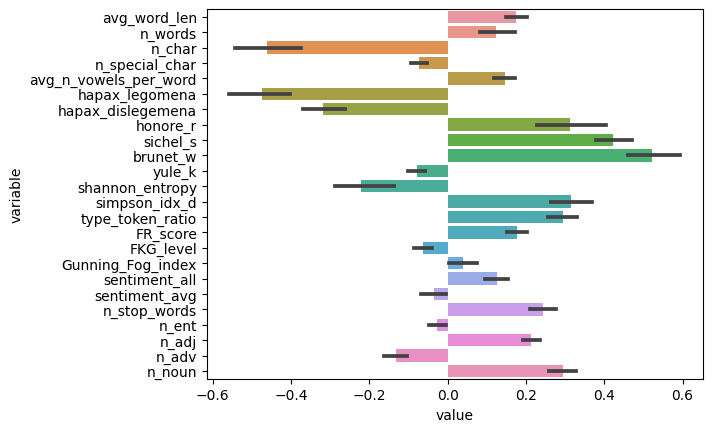

In [75]:
df_coefs = pd.DataFrame(m)
df_coefs.columns = col_use
sns.barplot(data=df_coefs.melt(), y="variable", x="value")
plt.show()

In [76]:
out, m = run_experiment(X_train_u[col_use], y_train_u, cv_Kfold, clf_lr_1)
print(
    'styllsitic f lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 79.03it/s]

styllsitic f lr C1 Accuracy 0.584+-0.012 F1 Score 0.585+-0.015  0.584+-0.012 | 0.585+-0.015


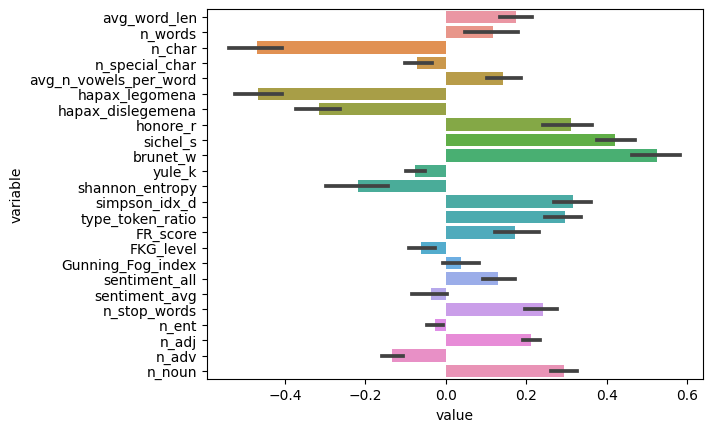

In [77]:
df_coefs = pd.DataFrame(m)
df_coefs.columns = col_use
sns.barplot(data=df_coefs.melt(), y="variable", x="value")
plt.show()